# **Skenario 3 - CNN MobileNet**

Skenario 3 menggunakan model Convolutional Neural Network (CNN) dengan arsitektur MobileNet untuk melakukan klasifikasi pada data citra otak.

---

## 1. Import packages

Import library yang digunakan untuk preprocessing data, membangun model, dan visualisas

In [7]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
import ipywidgets as widgets
from IPython.display import display
from PIL import Image
import io

## 2. Data Preparation

### 2.1 Load dan Eksplorasi Data
cari dan cetak data `selected_image.npz` di dalam struktur direktori dan menampilkan informasi tentang jumlah slice untuk setiap label dan plane

In [2]:
directory_path = r"D:\Documents\Kuliah\.SKRIPSI\KLASIFIKASI ALZHEIMER\Coding\Notebook\Preprocessing\selected_image.npz"
loaded_data = np.load(directory_path, allow_pickle=True)

combined_slices = loaded_data['combined_slices'].item()

for label, plane_slices in combined_slices.items():
    for plane, result_slices in plane_slices.items():
        total_slices = len(result_slices)
        
        print(f"Label: {label}, Plane: {plane}, Jumlah Total Slice: {total_slices}")

        # Menampilkan bentuk (shape) dari setiap slice
        for i, (position, resized_slice) in enumerate(result_slices):
            print(f"  Resized Slice {i+1} - Position: {position}, Shape: {resized_slice.shape}")

Label: AD, Plane: coronal, Jumlah Total Slice: 60
  Resized Slice 1 - Position: 107, Shape: (224, 224)
  Resized Slice 2 - Position: 111, Shape: (224, 224)
  Resized Slice 3 - Position: 110, Shape: (224, 224)
  Resized Slice 4 - Position: 122, Shape: (224, 224)
  Resized Slice 5 - Position: 121, Shape: (224, 224)
  Resized Slice 6 - Position: 123, Shape: (224, 224)
  Resized Slice 7 - Position: 132, Shape: (224, 224)
  Resized Slice 8 - Position: 131, Shape: (224, 224)
  Resized Slice 9 - Position: 133, Shape: (224, 224)
  Resized Slice 10 - Position: 136, Shape: (224, 224)
  Resized Slice 11 - Position: 135, Shape: (224, 224)
  Resized Slice 12 - Position: 137, Shape: (224, 224)
  Resized Slice 13 - Position: 136, Shape: (224, 224)
  Resized Slice 14 - Position: 137, Shape: (224, 224)
  Resized Slice 15 - Position: 135, Shape: (224, 224)
  Resized Slice 16 - Position: 133, Shape: (224, 224)
  Resized Slice 17 - Position: 132, Shape: (224, 224)
  Resized Slice 18 - Position: 131, Shape

### 2.2 Pembagian Data

Menyiapkan data dengan menggabungkan slice dan melakukan label encoding.

In [3]:
X = []
y = []

for label, plane_slices in combined_slices.items():
    for plane, result_slices in plane_slices.items():
        X.extend([np.expand_dims(slice_data, axis=-1) for _, slice_data in result_slices])
        y.extend([label] * len(result_slices))

X = np.array(X)
y = np.array(y)

In [4]:
# Label Encoding
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

## 3. Data Preprocessing

### 3.1 Normalisasi dan Penyesuaian Format Citra
Mengatur parameter untuk cross-validation dan menentukan nilai mean dan std untuk normalisasi data.

In [5]:
from sklearn.model_selection import StratifiedKFold

# Perform K-Fold cross-validation
n_splits = 5
kfold = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

mean = 0.485
std = 0.229

### 3.2 Cross - Validation
Melakukan cross-validation dengan 5 fold. Di dalam setiap fold

In [6]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, classification_report

# Inisialisasi k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = []

## 4. Training

In [8]:
for i, (train_index, test_index) in enumerate(kf.split(X, y), start=1):
    # Model MobileNet sbg base model
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    model = models.Sequential()
    model.add(base_model)
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4, activation='softmax'))

    # Setel base model gabisa dilatih
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Menyiapkan data train dan test dg label encoding
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    y_train_encoded = to_categorical(y_train, num_classes=4)
    y_test_encoded = to_categorical(y_test, num_classes=4)

    # Normalisasi dan ubah gambar grayscale menjadi RGB
    X_train_normalized = (X_train / 255.0 - mean) / std
    X_test_normalized = (X_test / 255.0 - mean) / std

    X_train_rgb = np.repeat(X_train_normalized, 3, axis=-1)
    X_test_rgb = np.repeat(X_test_normalized, 3, axis=-1)

    # Latih model
    model.fit(X_train_rgb, y_train_encoded, epochs=10, validation_data=(X_test_rgb, y_test_encoded))

    # Evaluasi model
    _, accuracy_fold = model.evaluate(X_test_rgb, y_test_encoded)
    y_pred = model.predict(X_test_rgb)
    y_pred_labels = np.argmax(y_pred, axis=1)
    classification_rep_fold = classification_report(np.argmax(y_test_encoded, axis=1), y_pred_labels)

    # Simpan skor dan menampilkannya
    print(f"Fold {i} - Accuracy: {accuracy_fold}")
    print("Classification Report:")
    print(classification_rep_fold)

    cv_scores.append(accuracy_fold)

17235968/17225924 [==============================] - 9s 1us/step
Epoch 1/10
18/18 [==============================] - 92s 4s/step - loss: 15.3873 - accuracy: 0.3559 - val_loss: 1.3158 - val_accuracy: 0.3958
Epoch 2/10
18/18 [==============================] - 61s 3s/step - loss: 1.2800 - accuracy: 0.4062 - val_loss: 1.2819 - val_accuracy: 0.3681
Epoch 3/10
18/18 [==============================] - 51s 3s/step - loss: 1.2161 - accuracy: 0.4705 - val_loss: 1.2534 - val_accuracy: 0.4583
Epoch 4/10
18/18 [==============================] - 58s 3s/step - loss: 1.1619 - accuracy: 0.4601 - val_loss: 1.0536 - val_accuracy: 0.5694
Epoch 5/10
18/18 [==============================] - 62s 3s/step - loss: 1.0752 - accuracy: 0.5000 - val_loss: 1.0275 - val_accuracy: 0.5486
Epoch 6/10
18/18 [==============================] - 62s 3s/step - loss: 1.0164 - accuracy: 0.5538 - val_loss: 0.9877 - val_accuracy: 0.6458
Epoch 7/10
18/18 [==============================] - 64s 4s/step - loss: 0.9855 - accuracy: 0.5

In [9]:
print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy: ", np.mean(cv_scores))

Cross-Validation Scores: [0.7013888955116272, 0.9305555820465088, 0.8958333134651184, 0.8402777910232544, 0.8958333134651184]
Mean Accuracy:  0.8527777791023254


Memvisualisasikan skor cross-validation dengan plot


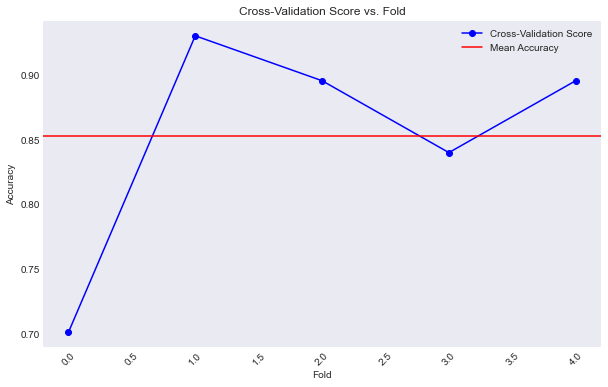

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(cv_scores, marker="o", color="blue", label="Cross-Validation Score")
plt.axhline(y=np.mean(cv_scores), color="red", linestyle="-", label="Mean Accuracy")

plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("Cross-Validation Score vs. Fold")
plt.legend()

plt.xticks(rotation=45)
plt.show()

## 5. Testing

### 5.1 Menilai model pada data uji

In [11]:
# Evaluasi model menggunakan data uji NumPy
evaluation_result = model.evaluate(X_test_rgb, y_test_encoded, verbose=1)

# Menampilkan hasil evaluasi
print("Loss:", evaluation_result[0])
print("Accuracy:", evaluation_result[1])

# Prediksi menggunakan data uji
predictions = model.predict(X_test_rgb)
predicted_labels = tf.argmax(predictions, axis=1).numpy()

print('Label Sebenarnya : ', np.argmax(y_test_encoded, axis=1))
print('Label Prediksi : ', predicted_labels)

5/5 [==============================] - 9s 2s/step - loss: 0.3276 - accuracy: 0.8958
Loss: 0.3276222348213196
Accuracy: 0.8958333134651184
Label Sebenarnya :  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]
Label Prediksi :  [0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 1 1 1 1 1 1 1 3 3 3 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 2 2 3 3 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 1
 3 3 2 2 1 3 3 3 2 2 3 3 3 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


### 5.2 Visualisasi beberapa gambar dari data uji

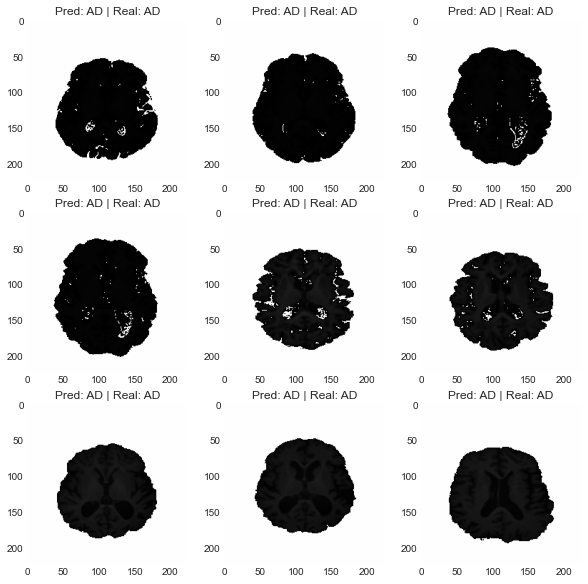

In [12]:
class_names = ["AD", "CN", "EMCI", "LMCI"]

plt.figure(figsize=(10, 10))
for i in range(min(9, len(X_test_rgb))):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(X_test_rgb[i].astype("uint8"))
    
    # Dapatkan label prediksi dan label sebenarnya
    true_label = np.argmax(y_test_encoded[i])
    plt.title("Pred: " + class_names[predicted_labels[i]] + " | Real: " + class_names[true_label])

plt.show()

## 6. Evaluasi

Menambahkan metrik specificity dan sensitivity ke model

In [ ]:
from keras import backend as K

def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', specificity, sensitivity])

Evaluasi model pada data train 

In [13]:
loss, accuracy, specificity, sensitivity = model.evaluate(X_train_rgb, y_train_encoded)
print('Loss train set: ', loss)
print('Akurasi train set: ', accuracy)
print('Specificity train set: ', specificity)
print('Sensitivity train set: ', sensitivity)

18/18 [==============================] - 42s 2s/step - loss: 0.0598 - accuracy: 0.9948


ValueError: not enough values to unpack (expected 4, got 2)

Evaluasi model pada data test

In [ ]:
loss, accuracy, specificity, sensitivity = model.evaluate(X_test_rgb, y_test_encoded)
print('Loss test set: ', loss)
print('Akurasi test set: ', accuracy)
print('Specificity test set: ', specificity)
print('Sensitivity test set: ', sensitivity)

visualisasi confusion matrix

In [ ]:
from sklearn.metrics import confusion_matrix
from itertools import product
from matplotlib.ticker import PercentFormatter

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15):
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    n_classes = cm.shape[0]

    fig, ax = plt.subplots(figsize=figsize)

    # Plot confusion matrix with colorbar
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        ax=ax,
        xticklabels=classes if classes else np.arange(n_classes),
        yticklabels=classes if classes else np.arange(n_classes),
        cbar_kws={"label": "Count", "format": "%d"},
    )

    # Set labels and title
    ax.set(
        title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
    )

    # Set tick positions and labels
    ax.xaxis.set_major_locator(plt.FixedLocator(np.arange(n_classes)))
    ax.yaxis.set_major_locator(plt.FixedLocator(np.arange(n_classes)))
    ax.set_xticklabels(classes if classes else np.arange(n_classes), rotation=45, fontsize=text_size)
    ax.set_yticklabels(classes if classes else np.arange(n_classes), rotation=0, fontsize=text_size)

    # Set threshold for text color
    threshold = (cm.max() + cm.min()) / 2.

    # Add text to each cell with percentage
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(
            j + 0.5,  
            i + 0.5,  
            f"{cm[i, j]} ({cm_norm[i, j] * 100:.1f}%)",
            ha="center",
            va="center",
            color="white" if cm[i, j] > threshold else "black",
            fontsize=text_size,
        )

    plt.tight_layout()
    plt.show()

In [ ]:
# Prediksi Label
y_pred = model.predict(X_test_rgb)
predicted_labels = np.argmax(y_pred, axis=1)

# Buat confusion matrix
make_confusion_matrix(np.argmax(y_test_encoded, axis=1), predicted_labels, class_names, figsize=(10,10),
                      text_size=15)

Visualisasi ROC_AUC

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(4):  
    fpr[i], tpr[i], _ = roc_curve(y_test_encoded[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Display ROC-AUC for each class
for i in range(4):
    print(f"Class {class_names[i]} - ROC-AUC: {roc_auc[i]}")

# Visualize ROC curves
plt.figure(figsize=(10, 6))

for i in range(4):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve for Multi-Class Classification')
plt.legend()
plt.show()